https://nixtlaverse.nixtla.io/neuralforecast/docs/tutorials/getting_started_complete.html

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from statsforecast import StatsForecast

from ray import tune

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoNHITS, AutoLSTM
from neuralforecast.losses.pytorch import MQLoss

import os

from datasetsforecast.losses import mse, mae, rmse
from datasetsforecast.evaluation import accuracy

plt.style.use('seaborn-v0_8')

In [17]:
Y_df = pd.read_parquet('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet')

print(Y_df.head())

# trim the data
uids = Y_df['unique_id'].unique()[:10]
Y_df = Y_df.query('unique_id in @uids').reset_index(drop=True)
print(Y_df.head())

print(Y_df.info())

Y_df['ds'] = Y_df['ds'].astype('datetime64[h]')

print(Y_df.info())
print(Y_df.head())

  unique_id  ds      y
0        H1   1  605.0
1        H1   2  586.0
2        H1   3  586.0
3        H1   4  559.0
4        H1   5  511.0
  unique_id  ds      y
0        H1   1  605.0
1        H1   2  586.0
2        H1   3  586.0
3        H1   4  559.0
4        H1   5  511.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7480 entries, 0 to 7479
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   unique_id  7480 non-null   object 
 1   ds         7480 non-null   int64  
 2   y          7480 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 175.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7480 entries, 0 to 7479
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype        
---  ------     --------------  -----        
 0   unique_id  7480 non-null   object       
 1   ds         7480 non-null   datetime64[s]
 2   y          7480 non-null   float64      
dtypes: datet

Explore the data

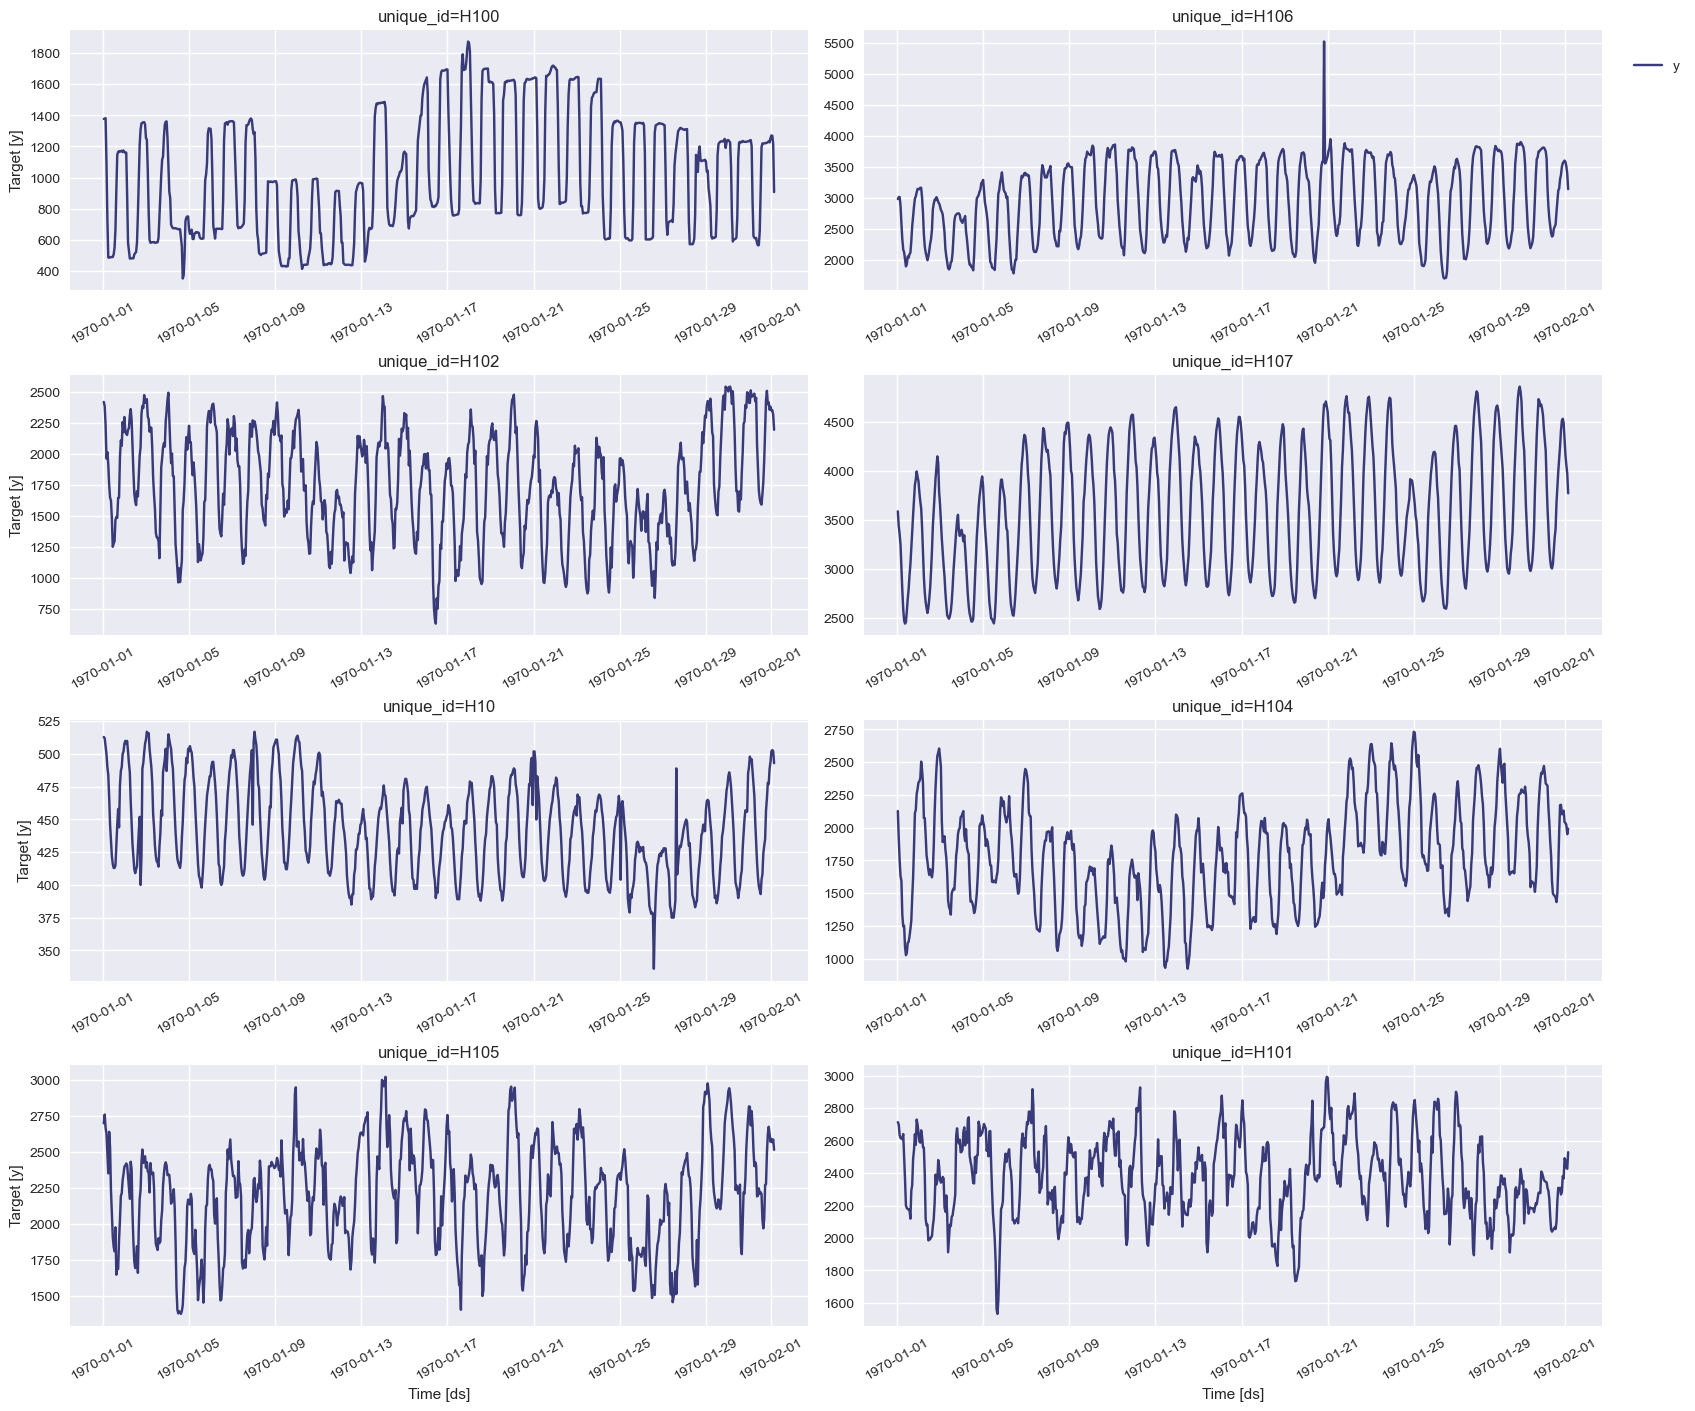

In [18]:
# plot 8 random series
StatsForecast.plot(
    df=Y_df,
    engine='matplotlib'
)

Train multiple models for many series

In [ ]:
# custom parameter grids for LSTM and NHITS with raytune
config_nhits = {
    "input_size":tune.choice(
            [48, 48*2, 48*3]
    ),
    "start_padding_enabled": True,
    "n_blocks": 5*[1],
    "mlp_units": 5*[
            [64, 64]
        ],
    "n_pool_kernel_size": tune.choice(
        [
            5*[1],
            5*[2],
            5*[4],
            [8, 4, 2, 1, 1],
        ]
    ),
    "n_freq_downsample": tune.choice(
        [
            [8, 4, 2, 1, 1],
            [1, 1, 1, 1, 1],
        ]
    ),
    "learning_rate": tune.loguniform(
        1e-4, 1e-2
    ),
    "scaler_type": tune.choice(
        [None]
    ),
    "max_steps": tune.choice(
        [1000]
    ),
    "batch_size": tune.choice(
        [1, 4, 10]
    ),
    "windows_batch_size": tune.choice(
        [128, 256, 512],
    ),
    "random_seed": tune.randint(
        1, 20
    ),
}

config_lstm = {
    "input_size": tune.choice(
        [
            48, 48*2, 48*3
        ]
    ),              
    "encoder_hidden_size": tune.choice(
        [64, 128]
    ),           
    "encoder_n_layers": tune.choice(
        [2, 4]
    ),                 
    "learning_rate": tune.loguniform(
        1e-4, 1e-2
    ),             
    "scaler_type": tune.choice(
        ['robust']
    ),                  
    "max_steps": tune.choice(
        [500, 1000]
    ),                    
    "batch_size": tune.choice(
        [1, 4]
    ),                      
    "random_seed": tune.randint(
        1, 20
    ),                   
}

In [ ]:

# set up the hyperparameter search
nf = NeuralForecast(
    models=[
        AutoNHITS(h=48,
                  config=config_nhits,
                  loss=MQLoss(),
                  num_samples=5,
                #   gpus=0,
        ),
        AutoLSTM(h=48,
                 config=config_lstm,
                 loss=MQLoss(),
                 num_samples=2,
                #  gpus=0,
        ),
    ],
    freq='H',
)

Training

In [21]:
nf.fit(df=Y_df)

(_train_tune pid=6518) /opt/miniconda3/envs/nixtla/lib/python3.12/site-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=6518) Seed set to 1
(_train_tune pid=6518) GPU available: True (mps), used: True
(_train_tune pid=6518) TPU available: False, using: 0 TPU cores
(_train_tune pid=6518) HPU available: False, using: 0 HPUs
(_train_tune pid=6518) 
(_train_tune pid=6518)   | Name            | Type          | Params | Mode 
(_train_tune pid=6518) ----------------------------------------------------------
(_train_tune pid=6518) 0 | loss            | MQLoss        | 5      | train
(_train_tune pid=6518) 1 | padder          | ConstantPad1d | 0      | train
(_train_tune pid=6518) 2 | scaler          | TemporalNorm  | 0      | train
(_train_tune pid=6518) 3 | hist_encoder    | LSTM          | 484 K  | train
(_train_

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=6518) /opt/miniconda3/envs/nixtla/lib/python3.12/multiprocessing/resource_tracker.py:254: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(_train_tune pid=6518)   warnings.warn('resource_tracker: There appear to be %d '
(_train_tune pid=6537) 
2024-11-29 12:35:06,545	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_8de0d_00001
Traceback (most recent call last):
  File "/opt/miniconda3/envs/nixtla/lib/python3.12/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/nixtla/lib/python3.12/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/nixtla/lib/python3.12/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


RuntimeError: No best trial found for the given metric: loss. This means that no trial has reported this metric, or all values reported for this metric are NaN. To not ignore NaN values, you can set the `filter_nan_and_inf` arg to False.

Predicting

In [ ]:
fcst_df = nf.predict()
fcst_df.columns = fcst_df.columns.str.replace('-median', ' ')
print(fcst_df.head())

StatsForecast.plot(
    Y_df,
    fcst_df,
    engine='matplotlib',
    max_insample_length=48 * 3,
    level=[80, 90]
)

# Plot to unique_ids and some selected models
StatsForecast.plot(
    Y_df,
    fcst_df,
    models=["AutoLSTM"],
    unique_ids=["H107", "H104"], 
    level=[80, 90],
    engine='matplotlib'
)

# Explore other models 
StatsForecast.plot(
    Y_df,
    fcst_df,
    models=["AutoNHITS"],
    unique_ids=["H10", "H105"],
    level=[80, 90],
    engine='matplotlib'
)



Exception: You must fit the model before predicting.

Evaluation with cross vaidation

In [ ]:
nf = NeuralForecast(
    models=[
        AutoNHITS(h=48, config=config_nhits, loss=MQLoss(), num_samples=5),
        AutoLSTM(h=48, config=config_lstm, loss=MQLoss(), num_samples=2), 
    ],
    freq='H'
)

# perform crossvalidation
cv_df = nf.cross_validation(Y_df, n_windows=2)

cv_df.columns = cv_df.columns.str.replace('-median', '')

print(cv_df.head())

for cutoff in cv_df['cutoff'].unique():
    StatsForecast.plot(
        Y_df, 
        cv_df.query('cutoff == @cutoff').drop(columns=['y', 'cutoff']), 
        max_insample_length=48 * 4, 
        unique_ids=['H185'],
        engine='matplotlib'
    )

Evaluation with metrics

In [ ]:
# global evaluation df
evaluation_df = accuracy(
    cv_df,
    [mse, mae, rmse],
    agg_by=['unique_id']
)
evaluation_df['best_model'] = evaluation_df.drop(
    columns=['metric', 'unique_id']
    ).idxmin(
        axis=1
)
    
print(evaluation_df.head())

# evaluation df per timeseries
summary_df = (evaluation_df
              .groupby(['metric', 'best_model'])
              .size()
              .sort_values()
              .to_frame())

summary_df = summary_df.reset_index()
summary_df.columns = ['metric', 'model', 'nr. of unique_ids']

print(summary_df)

print(summary_df.query('metric == "mse"'))

# plot
nhits_ids = (evaluation_df
             .query('best_model == "AutoNHITS" and metric == "mse"')
             ['unique_id']
             .unique()
)

StatsForecast.plot(
    Y_df,
    fcst_df, 
    unique_ids=nhits_ids,
    engine='matplotlib'
)
